# Introduction
Author: Reuben Jooste (u21457060)

## Assignment Details
For this assignment we are required to implement and compare two algorithms for multi-level thresholding: Simulated Annealing and Variable Neighbourhood Search.

Thresholding will be performed at various levels for each of the input images (there are 5). The levels include k= 2,3,4,5.

The objective functions to be used include the Otsu and Kapur methods.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Libraries

In [2]:
!pip install pythreshold

  Preparing metadata (setup.py) ... done
  Created wheel for pythreshold: filename=pythreshold-0.3.1-py3-none-any.whl size=25022 sha256=c7f2d54b66159b2cbd0558135b14e49676a682dfdd2419a25e0f6cbb5415513e
  Stored in directory: /root/.cache/pip/wheels/ad/e3/3e/8e8bcadca9c0f03f52b52c05ea7b74cf20dcadb8e69317bffd
Successfully built pythreshold


In [3]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from itertools import combinations
import random
import math
import os
# import thresholding methods
from pythreshold.utils import apply_multithreshold
# import metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# Temporary fix for libraries using deprecated np.float
if not hasattr(np, 'float'):
    np.float = float

### Load the input images

T22.jpg  shape: (256, 256)


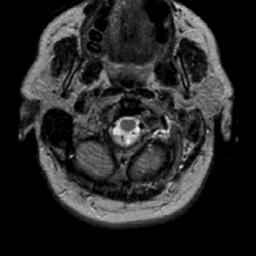

T32.jpg  shape: (256, 256)


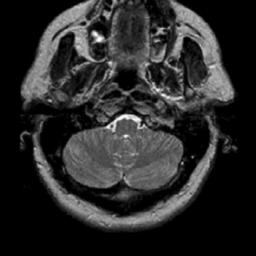

T42.jpg  shape: (256, 256)


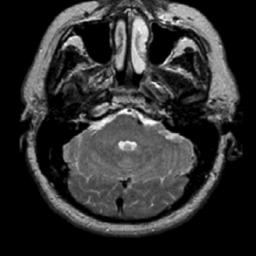

T52.jpg  shape: (256, 256)


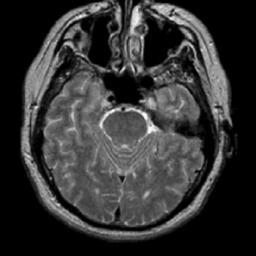

T62.jpg  shape: (256, 256)


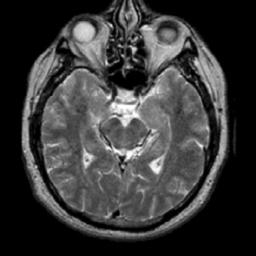

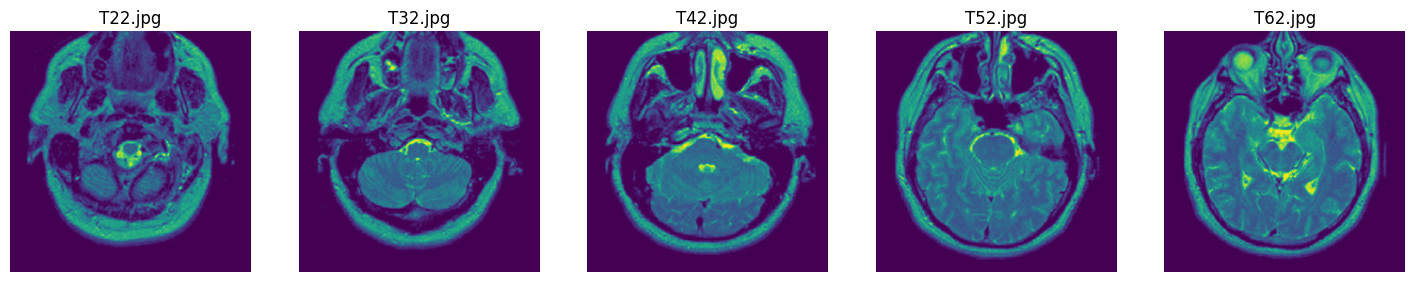

In [4]:
img_names = ['T22.jpg', 'T32.jpg', 'T42.jpg', 'T52.jpg', 'T62.jpg']
img_paths = []
for i in range(5):
    img_paths.append(f'/content/drive/MyDrive/University/Honours/COS791/Assignments/A2/images/{img_names[i]}')
input_imgs = []

# create figure
fig = plt.figure(figsize=(18, 7))

# setting values to rows and column variables
rows = 1
columns = 5

for i in range(5):
    # create and add image
    # img = cv2.imread(f'/kaggle/input/cos791-a2-input-images/{img_names[i]}', 0)
    img = cv2.imread(f'/content/drive/MyDrive/University/Honours/COS791/Assignments/A2/images/{img_names[i]}')
    input_imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    print(img_names[i], ' shape:', input_imgs[i].shape)

    # Adds a subplot at the ith position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(input_imgs[i])
    plt.axis('off')
    plt.title(f"{img_names[i]}")

    cv2_imshow(input_imgs[i])


### Helper Functions

In [11]:
# Helper function to generate random thresholds
def generate_threshold_combinations(levels):
    return sorted(random.sample(range(1, 255), levels-1))

# neighbour function
def get_neighbour(x, step_size):
    new_neighbour = x[:]
    for i in range(len(x)):
        new_neighbour[i] += int(random.uniform(-step_size, step_size))

        if new_neighbour[i] < 0:
            new_neighbour[i] = 0
        elif new_neighbour[i] > 255:
            new_neighbour[i] = 255

    return new_neighbour

# calculate the total variance for given thresholds (Otsu):
# NOTE: THIS FUNCTION WAS ADAPTED FROM A PUBLIC OPEN SOURCE LIBRARY FOUND AT THIS LINK: https://github.com/manuelaguadomtz/pythreshold/tree/master
# DUE TO THE NATURE OF THIS ASSIGNMENT WE ADAPTED THE LIBRARY'S PRIVATE METHOD TO FIT OUR NEEDS
def calc_variance(histogram, cumulative_histogram, cumulative_distribution, thresholds):
    total_variance = 0

    # Iterate through all regions defined by the thresholds
    for index in range(len(thresholds) - 1):
        # Define the region between two thresholds
        lower_threshold = thresholds[index] + 1
        upper_threshold = thresholds[index + 1]

        if lower_threshold < 0:
            lower_threshold = 0
        elif upper_threshold > 255:
            upper_threshold = 255

        if upper_threshold < 0:
            upper_threshold = 0
        elif lower_threshold > 255:
            lower_threshold = 255

        # Region weight: Sum of the histogram between the thresholds
        region_weight = cumulative_histogram[upper_threshold - 1] - cumulative_histogram[lower_threshold - 1]

        # Region CDF: Sum of pixel intensities multiplied by their histogram counts
        region_cdf = cumulative_distribution[upper_threshold - 1] - cumulative_distribution[lower_threshold - 1]

        # Calculate region mean: Average intensity for this region
        if region_weight != 0:
            region_mean = region_cdf / region_weight
        else:
            region_mean = 0  # If no pixels in the region, avoid division by zero

        # Contribution of this region to total variance
        total_variance += region_weight * region_mean ** 2

    return total_variance

# calculate the total enropy for given thresholds (Kapur)
# NOTE: THIS FUNCTION WAS ADAPTED FROM A PUBLIC OPEN SOURCE LIBRARY FOUND AT THIS LINK: https://github.com/manuelaguadomtz/pythreshold/tree/master
# DUE TO THE NATURE OF THIS ASSIGNMENT WE ADAPTED THE LIBRARY'S PRIVATE METHOD TO FIT OUR NEEDS
def calc_entropy(histogram, cumulative_histogram, thresholds):
    total_entropy_value = 0
    for index in range(len(thresholds) - 1):
        # Thresholds
        lower_threshold = thresholds[index] + 1
        upper_threshold = thresholds[index + 1]

        if lower_threshold < 0:
            lower_threshold = 0
        elif upper_threshold > 255:
            upper_threshold = 255

        if upper_threshold < 0:
            upper_threshold = 0
        elif lower_threshold > 255:
            lower_threshold = 255

        # Cumulative histogram
        histogram_value = cumulative_histogram[upper_threshold - 1] - cumulative_histogram[lower_threshold - 1]

        # Normalized histogram
        normalized_values = histogram[lower_threshold:upper_threshold] / histogram_value if histogram_value > 0 else 1

        # Calculate entropy
        region_entropy = -(normalized_values * np.log(normalized_values + (normalized_values <= 0))).sum()

        # Updating total entropy
        total_entropy_value += region_entropy

    return total_entropy_value


# plot the original image, histogram, and thresholded image
def plot_figures(img, thresholds, title, img_name, level, segmented_img, masked_image, algo_name, method):
    # -- first we generate the threshold regions
    # ensure the bins are monotonically increasing
    thresholds = sorted(thresholds)
    regions = np.digitize(img, bins=thresholds)
    # -- create the histogram from the original image
    hist = img.ravel()

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 3))

    # Plotting the original image.
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'T-Level {level} - Original: {img_name}')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].plot(hist, color='skyblue')
    ax[1].set_title(f'T-Level {level} - Histogram: {img_name}')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r', linestyle='--')
        # add text
        ax[1].text(thresh+15, ax[1].get_ylim()[1]*0.8, f'{int(thresh)}', color='r', ha='left', va='center', fontsize=9, rotation=90)
    ax[1].set_xlabel('Pixel Intensity')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlim([0, 255])

    # Plotting the thresholding image result.
    ax[2].imshow(regions, cmap='jet')
    ax[2].set_title(f'T-Level {level} - {title}: {img_name}')
    ax[2].axis('off')

    ax[3].imshow(masked_image, cmap='gray')
    ax[3].set_title(f'T-Level {level} - {title} Result: {img_name}')
    ax[3].axis('off')

    plt.subplots_adjust()

    # save the image
    folder_path = '/content/drive/MyDrive/University/Honours/COS791/Assignments/A2/output'

    # Check if the folder exists
    if not os.path.exists(f'{folder_path}/{algo_name}_{method}_output_imgs_{img_name}'):
        # If it doesn't exist, create it
        os.makedirs(f'{folder_path}/{algo_name}_{method}_output_imgs_{img_name}')
    # Save the image to a file
    plt.savefig(f'{folder_path}/{algo_name}_{method}_output_imgs_{img_name}/{algo_name}_{method}_level_{level}_output_{img_name}.png', bbox_inches='tight', pad_inches=0)

    # display the image
    plt.show()


# def multilevel_otsu_variance(image, thresholds):
#     # Compute the histogram of the image
#     hist, bin_edges = np.histogram(image.ravel(), bins=256, range=(0, 256))
#     hist = hist.astype(np.float32) / hist.sum()  # Normalize the histogram

#     # Total mean intensity of the image
#     total_mean = np.sum([i * hist[i] for i in range(256)])

#     # Append 0 and 255 as the boundaries
#     thresholds = [0] + sorted(thresholds) + [255]

#     # Between-class variance
#     between_class_variance = 0.0

#     for i in range(len(thresholds) - 1):
#         # Class range: thresholds[i] to thresholds[i+1]
#         class_range = range(thresholds[i], thresholds[i + 1] + 1)

#         # Class probability (sum of histogram values in this range)
#         prob_class = np.sum([hist[j] for j in class_range])

#         # If the class probability is 0, skip this class
#         if prob_class == 0:
#             continue

#         # Class mean intensity
#         mean_class = np.sum([j * hist[j] for j in class_range]) / prob_class

#         # Update the between-class variance
#         between_class_variance += prob_class * (mean_class - total_mean) ** 2

#     return between_class_variance

### Metric Functions

In [6]:
# --- Comptue the evaluation score
def evaluate_image(img1, img2):
    # Ensure that the window size is appropriate for the image size
    min_image_size = min(img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1])
    win_size = 5 if min_image_size < 7 else 7  # Use smaller win_size if needed

    # Calculate SSIM with the adjusted window size
    ssim = structural_similarity(img1, img2, full=True, win_size=win_size)[0]
    psnr = peak_signal_noise_ratio(img1, img2)
    return psnr, ssim

### Objective Functions

In [7]:
# -- Otsu
def apply_otsu(image, hist, c_hist, cdf, nthrs):
    thresholds = sorted([random.randint(0, 255) for _ in range(nthrs)])
    eval = calc_variance(hist, c_hist, cdf, thresholds)
    # eval = multilevel_otsu_variance(image, thresholds)
    return thresholds, eval
# -- Kapur
def apply_kapur(image, hist, c_hist, cdf, nthrs):
    thresholds = sorted([random.randint(0, 255) for _ in range(nthrs)])
    eval = calc_entropy(hist, c_hist, thresholds)
    return thresholds, eval

### Implement Algorithms

In [8]:
# --- Simulated Annealing
def simulated_annealing(img, objective, curr_level, n_iterations, step_size, temp, method):
    if curr_level <= 1:
        raise ValueError("Thresholding level cannot be 0 or 1")

    # first define the histogram and CDF
    # Histogram
    if method == 'otsu':
        hist = np.histogram(img, bins=range(256))[0].astype(np.float)

        # Cumulative histograms
        c_hist = np.cumsum(hist)
        cdf = np.cumsum(np.arange(len(hist)) * hist)
    else: # method == 'kapur'
        hist, _ = np.histogram(img, bins=range(256), density=True)

        # Cumulative histogram
        c_hist = hist.cumsum()
        cdf = None

    # initialise current solution
    curr_best_thresholds, curr_best_eval = objective(img, hist, c_hist, cdf, curr_level)
    print(f'Initial Thresholds: {curr_best_thresholds}')
    print(f'Initial Evaluation: {curr_best_eval}')
    current = curr_best_thresholds
    current_eval = curr_best_eval

    last_10_evals = []

    for i in range(n_iterations):
        t = temp * (1 - (i / n_iterations))
        # generate a neighbour
        candidate_thresholds = get_neighbour(curr_best_thresholds, step_size)
        candidate_eval = calc_variance(hist, c_hist, cdf, candidate_thresholds) if method == 'otsu' else calc_entropy(hist, c_hist, candidate_thresholds)

        # check if candidate is better
        if candidate_eval > curr_best_eval or random.random() < np.exp((current_eval - candidate_eval) / t):
            current, current_eval = candidate_thresholds, candidate_eval

            # check if current is better than best
            if current_eval > curr_best_eval:
                curr_best_thresholds, curr_best_eval = candidate_thresholds, candidate_eval

        # start checking the stopping condition once we have done a few iterations
        if i > 100:
            if len(last_10_evals) >= 10:
                recent_improvements = [(last_10_evals[i] - last_10_evals[i-1]) / last_10_evals[i-1] for i in range(1, 10)]
                if all(improvement < 0.01 for improvement in recent_improvements):
                    print(f"Stopping early at Iteration {i+1} due to minimal improvements.")
                    break
                # remove first fitness
                last_10_evals.pop(0)
            # track best fitness values
            last_10_evals.append(curr_best_eval)

        # Optional: print progress
        if i % 100 == 0:
            print(f"Iteration {i+1}, Temperature {t:.3f}, Best Evaluation {curr_best_eval:.5f}")

    return curr_best_thresholds, curr_best_eval

In [9]:
# -- Variable Neighbourhood Search
def variable_neighbourhood_search(img, objective, curr_level, n_iterations, step_size, neighbourhood_size, method):
    if curr_level <= 1:
        raise ValueError("Thresholding level cannot be 0 or 1")

    # first define the histogram and CDF
    # Histogram
    if method == 'otsu':
        hist = np.histogram(img, bins=range(256))[0].astype(np.float)

        # Cumulative histograms
        c_hist = np.cumsum(hist)
        cdf = np.cumsum(np.arange(len(hist)) * hist)
    else: # method == 'kapur'
        hist, _ = np.histogram(img, bins=range(256), density=True)

        # Cumulative histogram
        c_hist = hist.cumsum()
        cdf = None
    # Initialise a solution
    curr_best_thresholds, curr_best_eval = objective(img, hist, c_hist, cdf, curr_level)
    print(f'Initial Thresholds: {curr_best_thresholds}')
    print(f'Initial Evaluation: {curr_best_eval}')
    current = curr_best_thresholds
    current_eval = curr_best_eval

    last_10_evals = []

    for i in range(n_iterations):
        for n in range(neighbourhood_size):
            candidate_thresholds = get_neighbour(current, step_size)
            candidate_eval = calc_variance(hist, c_hist, cdf, candidate_thresholds) if method == 'otsu' else calc_entropy(hist, c_hist, candidate_thresholds)

            # check if candidate is better
            if candidate_eval > curr_best_eval:
                curr_best_thresholds, curr_best_eval = candidate_thresholds, candidate_eval

        # start checking the stopping condition once we have done a few iterations
        if i > 100:
            if len(last_10_evals) >= 10:
                recent_improvements = [(last_10_evals[i] - last_10_evals[i-1]) / last_10_evals[i-1] for i in range(1, 10)]
                if all(improvement < 0.01 for improvement in recent_improvements):
                    print(f"Stopping early at Iteration {i+1} due to minimal improvements.")
                    break
                # remove first fitness
                last_10_evals.pop(0)
            # track best fitness values
            last_10_evals.append(curr_best_eval)

        current, current_eval = curr_best_thresholds, curr_best_eval

        if i % 100 == 0:
            print(f"Iteration {i + 1}: Best thresholds: {curr_best_thresholds}, Evaluation: {curr_best_eval}")

    return curr_best_thresholds, curr_best_eval

### Main Program

In [13]:
# function to run the simulated annealing algorithm
def run_algorithm(input_imgs, img_names, levels, algorithm, algo_name, algo_params):
    print('*'*100)
    print('*'*42, f'Running {algo_name}', '*'*42)
    print('*'*100)
    best_psnr = {}
    best_ssim = {}
    best_thresholds = {}
    best_evaluations = {}

    for i, img in enumerate(input_imgs):
        if img_names[i] not in best_psnr:
            best_psnr[img_names[i]] = {}
        if img_names[i] not in best_ssim:
            best_ssim[img_names[i]] = {}
        if img_names[i] not in best_thresholds:
            best_thresholds[img_names[i]] = {}
        if img_names[i] not in best_evaluations:
            best_evaluations[img_names[i]] = {}

        print('='*100)
        print('='*42, f' Image {img_names[i]}', '='*42)

        for level in levels:
            if f'Multi-Otsu Level {level}' not in best_psnr[img_names[i]]:
                best_psnr[img_names[i]][f'Multi-Otsu Level {level}'] = None
                best_ssim[img_names[i]][f'Multi-Otsu Level {level}'] = None
            if f'Multi-Kapur Level {level}' not in best_psnr[img_names[i]]:
                best_psnr[img_names[i]][f'Multi-Kapur Level {level}'] = None
                best_ssim[img_names[i]][f'Multi-Kapur Level {level}'] = None
            if f'Multi-Otsu Level {level}' not in best_thresholds[img_names[i]]:
                best_thresholds[img_names[i]][f'Multi-Otsu Level {level}'] = None
                best_evaluations[img_names[i]][f'Multi-Otsu Level {level}'] = None
            if f'Multi-Kapur Level {level}' not in best_thresholds[img_names[i]]:
                best_thresholds[img_names[i]][f'Multi-Kapur Level {level}'] = None
                best_evaluations[img_names[i]][f'Multi-Kapur Level {level}'] = None

            print('='*10, f' Level: {level}', '='*10)

            # extract the parameters
            if algo_name == 'SA':
                apply_otsu, apply_kapur, n_iterations, step_size, initial_temp = algo_params
                # apply the algorithm
                otsu_thresholds, otsu_eval = algorithm(img, apply_otsu, level, n_iterations, step_size, initial_temp, method='otsu')
                kapur_thresholds, kapur_eval = algorithm(img, apply_kapur, level, n_iterations, step_size, initial_temp, method='kapur')

            elif algo_name == 'VNS':
                apply_otsu, apply_kapur, n_iterations, step_size, neighbourhood_size = algo_params
                # apply the algorithm
                otsu_thresholds, otsu_eval = algorithm(img, apply_otsu, level, n_iterations, step_size, neighbourhood_size, method='otsu')
                kapur_thresholds, kapur_eval = algorithm(img, apply_kapur, level, n_iterations, step_size, neighbourhood_size, method='kapur')


            # print the best thresholds and scores
            print(f'Best Multi-Otsu {algo_name} solution: {otsu_thresholds}')
            print(f'Best Multi-Otsu {algo_name} evaluation: {otsu_eval}')
            print(f'Best Multi-Kapur {algo_name} solution: {kapur_thresholds}')
            print(f'Best Multi-Kapur {algo_name} evaluation: {kapur_eval}')

            # apply the thresholds on the input image
            otsu_thresholed_img = apply_multithreshold(img, otsu_thresholds)
            kapur_thresholed_img = apply_multithreshold(img, kapur_thresholds)

            # create masked image
            otsu_masked_image = img * otsu_thresholed_img
            kapur_masked_image = img * kapur_thresholed_img

            # compute the metric scores
            otsu_psnr, otsu_ssim = evaluate_image(img, otsu_thresholed_img)
            kapur_psnr, kapur_ssim = evaluate_image(img, kapur_thresholed_img)

            # save the scores
            best_psnr[img_names[i]][f'Multi-Otsu Level {level}'] = otsu_psnr
            best_ssim[img_names[i]][f'Multi-Otsu Level {level}'] = otsu_ssim
            best_psnr[img_names[i]][f'Multi-Kapur Level {level}'] = kapur_psnr
            best_ssim[img_names[i]][f'Multi-Kapur Level {level}'] = kapur_ssim
            best_thresholds[img_names[i]][f'Multi-Otsu Level {level}'] = otsu_thresholds
            best_thresholds[img_names[i]][f'Multi-Kapur Level {level}'] = kapur_thresholds
            best_evaluations[img_names[i]][f'Multi-Otsu Level {level}'] = otsu_eval
            best_evaluations[img_names[i]][f'Multi-Kapur Level {level}'] = kapur_eval

            print(f'Multi-Otsu {algo_name} (PSNR): {otsu_psnr}')
            print(f'Multi-Otsu {algo_name} (SSIM): {otsu_ssim}')
            print(f'Multi-Kapur {algo_name} (PSNR): {kapur_psnr}')
            print(f'Multi-Kapur {algo_name} (SSIM): {kapur_ssim}')

            print('='*50)

            # plot the original image, its histogram, and the thresholded image
            plot_figures(img, otsu_thresholds, f'Multi-Otsu {algo_name}', img_names[i], level, otsu_thresholed_img, otsu_masked_image, algo_name, 'Otsu')
            plot_figures(img, kapur_thresholds, f'Multi-Kapur {algo_name}', img_names[i], level, kapur_thresholed_img, kapur_masked_image, algo_name, 'Kapur')

        # save everything for the current image
        folder_path = '/content/drive/MyDrive/University/Honours/COS791/Assignments/A2/output'

        # Check if the folder exists
        if not os.path.exists(f'{folder_path}/{algo_name}_output_scores_{img_names[i]}'):
            # If it doesn't exist, create it
            os.makedirs(f"{folder_path}/{algo_name}_output_scores_{img_names[i]}")
        # Save the data to a file
        with open(f"{folder_path}/{algo_name}_output_scores_{img_names[i]}/{algo_name}_{img_names[i]}_level_scores.txt", "w") as file:
            file.write(f"Best PSNR: {best_psnr[img_names[i]]}\n")
            file.write(f"Best SSIM: {best_ssim[img_names[i]]}\n")
            file.write(f"Best Thresholds: {best_thresholds[img_names[i]]}\n")
            file.write(f"Best Evaluations: {best_evaluations[img_names[i]]}\n")

# ==============================================================================
# Main program
# ==============================================================================
# ==============================================================================
# our main program will run through a number of defined thresholding levels
random.seed(99)
initial_temp = 100
n_iterations = 1000
step_size = 10
levels = [2, 3, 4, 5]
neighbourhood_size = 5
SA_algo_params = [apply_otsu, apply_kapur, n_iterations, step_size, initial_temp]
VNS_algo_params = [apply_otsu, apply_kapur, n_iterations, step_size, neighbourhood_size]

run_algorithm(input_imgs, img_names, levels, simulated_annealing, 'SA', SA_algo_params)
run_algorithm(input_imgs, img_names, levels, variable_neighbourhood_search, 'VNS', VNS_algo_params)


Output hidden; open in https://colab.research.google.com to view.